In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [1]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img
    

In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



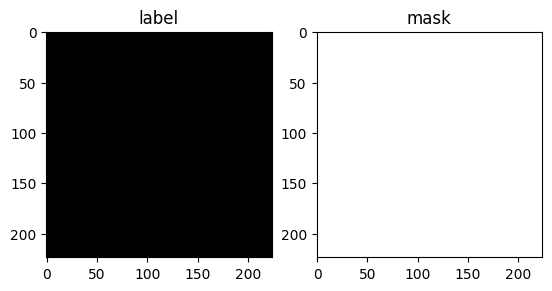

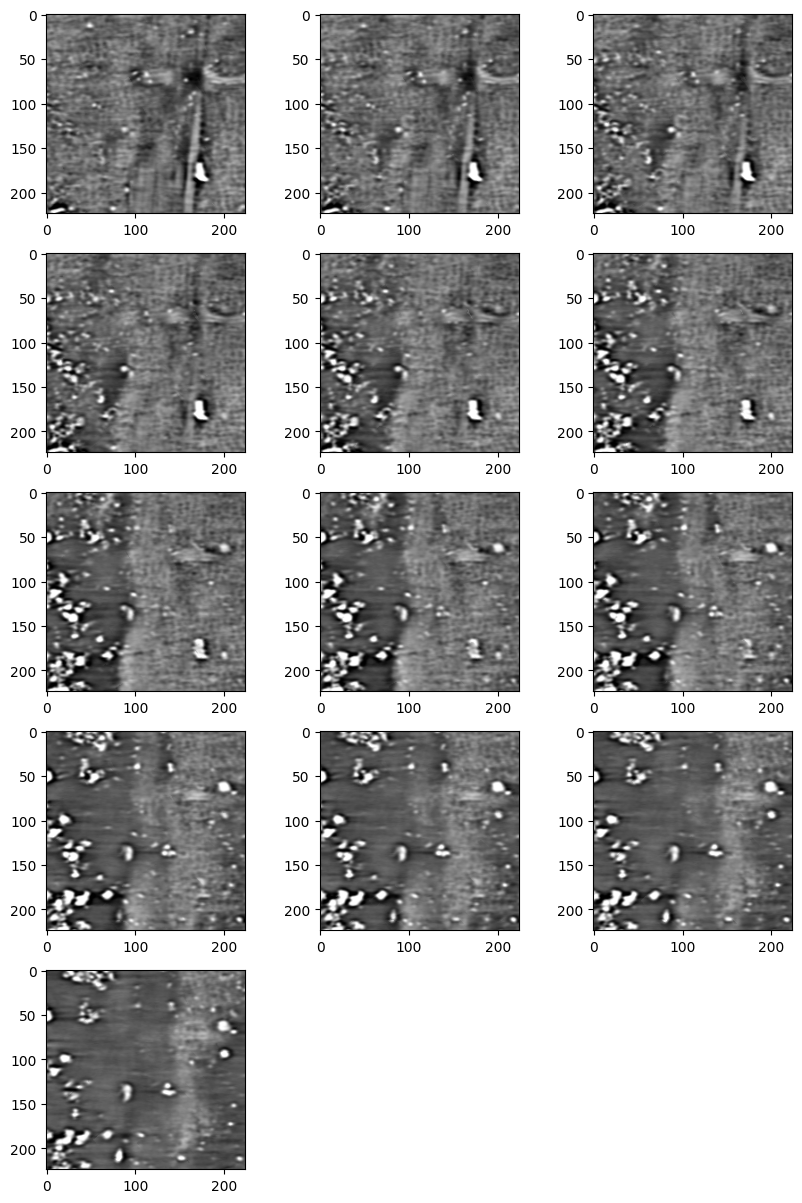

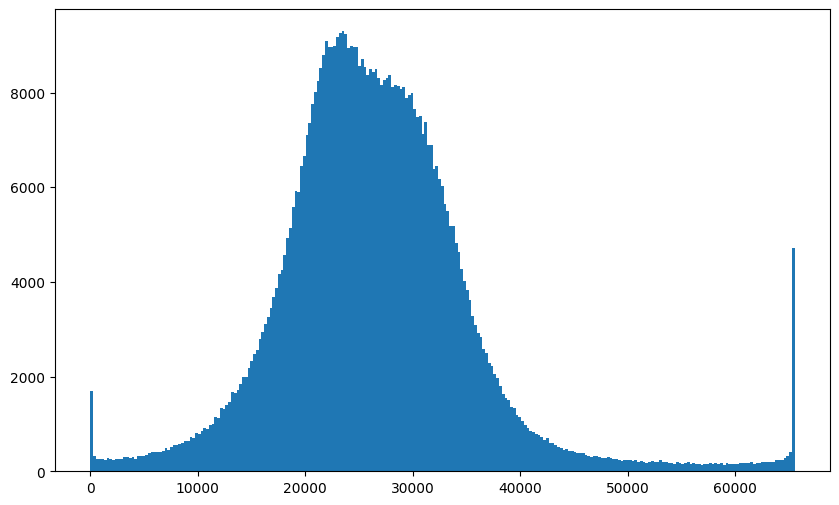

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


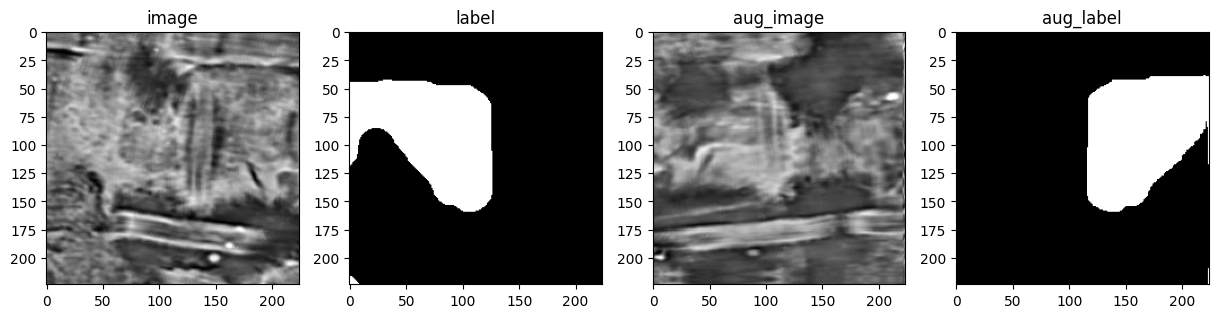

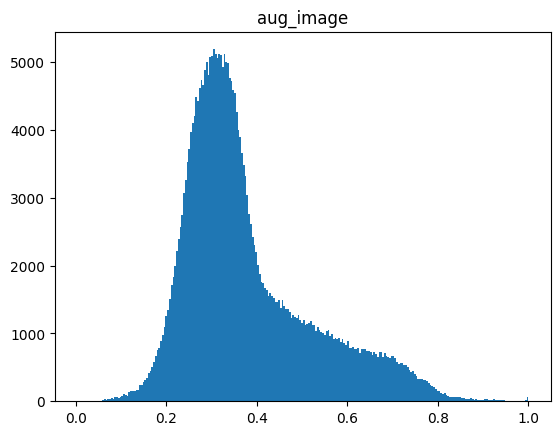

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|██████████| 131/131 [00:07<00:00, 17.23it/s]


fbeta: 0.3452
Epoch 1 - avg_train_loss: 1.3911  avg_val_loss: 1.1175  avgScore: 0.3452  time: 84s
Epoch 1 - Save Best Loss: 1.1175  Best Score: 0.3452 Model



100%|██████████| 131/131 [00:07<00:00, 18.01it/s]


fbeta: 0.3850
Epoch 2 - avg_train_loss: 1.1920  avg_val_loss: 1.0275  avgScore: 0.3850  time: 79s
Epoch 2 - Save Best Loss: 1.0275  Best Score: 0.3850 Model



100%|██████████| 131/131 [00:07<00:00, 17.76it/s]


fbeta: 0.3815
Epoch 3 - avg_train_loss: 1.0189  avg_val_loss: 0.9792  avgScore: 0.3815  time: 78s



100%|██████████| 131/131 [00:07<00:00, 17.98it/s]


fbeta: 0.3700
Epoch 4 - avg_train_loss: 0.9140  avg_val_loss: 0.8979  avgScore: 0.3700  time: 78s



100%|██████████| 131/131 [00:07<00:00, 17.81it/s]


fbeta: 0.4059
Epoch 5 - avg_train_loss: 0.8499  avg_val_loss: 0.9378  avgScore: 0.4059  time: 78s
Epoch 5 - Save Best Loss: 0.9378  Best Score: 0.4059 Model



100%|██████████| 131/131 [00:07<00:00, 17.52it/s]


fbeta: 0.4094
Epoch 6 - avg_train_loss: 0.8353  avg_val_loss: 0.9276  avgScore: 0.4094  time: 81s
Epoch 6 - Save Best Loss: 0.9276  Best Score: 0.4094 Model



100%|██████████| 131/131 [00:07<00:00, 17.42it/s]


fbeta: 0.5146
Epoch 7 - avg_train_loss: 0.8089  avg_val_loss: 0.8532  avgScore: 0.5146  time: 80s
Epoch 7 - Save Best Loss: 0.8532  Best Score: 0.5146 Model



100%|██████████| 131/131 [00:07<00:00, 17.35it/s]


fbeta: 0.4000
Epoch 8 - avg_train_loss: 0.7808  avg_val_loss: 1.0124  avgScore: 0.4000  time: 80s



100%|██████████| 131/131 [00:07<00:00, 18.12it/s]


fbeta: 0.4299
Epoch 9 - avg_train_loss: 0.7835  avg_val_loss: 0.9415  avgScore: 0.4299  time: 79s



100%|██████████| 131/131 [00:07<00:00, 17.59it/s]


fbeta: 0.4940
Epoch 10 - avg_train_loss: 0.7190  avg_val_loss: 0.9103  avgScore: 0.4940  time: 80s



100%|██████████| 131/131 [00:07<00:00, 17.79it/s]


fbeta: 0.4598
Epoch 11 - avg_train_loss: 0.7312  avg_val_loss: 0.8840  avgScore: 0.4598  time: 80s



100%|██████████| 131/131 [00:07<00:00, 17.69it/s]


fbeta: 0.3906
Epoch 12 - avg_train_loss: 0.7018  avg_val_loss: 0.9446  avgScore: 0.3906  time: 80s



100%|██████████| 131/131 [00:07<00:00, 18.02it/s]


fbeta: 0.4373
Epoch 13 - avg_train_loss: 0.6659  avg_val_loss: 0.9164  avgScore: 0.4373  time: 80s



100%|██████████| 131/131 [00:07<00:00, 18.06it/s]


fbeta: 0.4919
Epoch 14 - avg_train_loss: 0.6521  avg_val_loss: 0.8797  avgScore: 0.4919  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.09it/s]


fbeta: 0.5026
Epoch 15 - avg_train_loss: 0.6288  avg_val_loss: 0.8885  avgScore: 0.5026  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.10it/s]


fbeta: 0.4801
Epoch 16 - avg_train_loss: 0.6123  avg_val_loss: 0.8968  avgScore: 0.4801  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4906
Epoch 17 - avg_train_loss: 0.5954  avg_val_loss: 0.8827  avgScore: 0.4906  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.06it/s]


fbeta: 0.4643
Epoch 18 - avg_train_loss: 0.5911  avg_val_loss: 0.9020  avgScore: 0.4643  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.08it/s]


fbeta: 0.4726
Epoch 19 - avg_train_loss: 0.5707  avg_val_loss: 0.9058  avgScore: 0.4726  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.13it/s]


fbeta: 0.5108
Epoch 20 - avg_train_loss: 0.5531  avg_val_loss: 0.8836  avgScore: 0.5108  time: 79s

fold: 1


100%|██████████| 120/120 [00:06<00:00, 17.52it/s]


fbeta: 0.3322
Epoch 1 - avg_train_loss: 1.4312  avg_val_loss: 0.9068  avgScore: 0.3322  time: 81s
Epoch 1 - Save Best Loss: 0.9068  Best Score: 0.3322 Model



100%|██████████| 120/120 [00:07<00:00, 16.87it/s]


fbeta: 0.4228
Epoch 2 - avg_train_loss: 1.2387  avg_val_loss: 0.8354  avgScore: 0.4228  time: 82s
Epoch 2 - Save Best Loss: 0.8354  Best Score: 0.4228 Model



100%|██████████| 120/120 [00:07<00:00, 17.12it/s]


fbeta: 0.4810
Epoch 3 - avg_train_loss: 1.0670  avg_val_loss: 0.6536  avgScore: 0.4810  time: 83s
Epoch 3 - Save Best Loss: 0.6536  Best Score: 0.4810 Model



100%|██████████| 120/120 [00:07<00:00, 17.08it/s]


fbeta: 0.4866
Epoch 4 - avg_train_loss: 0.9282  avg_val_loss: 0.6215  avgScore: 0.4866  time: 82s
Epoch 4 - Save Best Loss: 0.6215  Best Score: 0.4866 Model



100%|██████████| 120/120 [00:07<00:00, 17.09it/s]


fbeta: 0.3844
Epoch 5 - avg_train_loss: 0.9084  avg_val_loss: 0.6565  avgScore: 0.3844  time: 82s



100%|██████████| 120/120 [00:07<00:00, 17.10it/s]


fbeta: 0.6002
Epoch 6 - avg_train_loss: 0.8367  avg_val_loss: 0.5906  avgScore: 0.6002  time: 81s
Epoch 6 - Save Best Loss: 0.5906  Best Score: 0.6002 Model



100%|██████████| 120/120 [00:07<00:00, 17.08it/s]


fbeta: 0.5921
Epoch 7 - avg_train_loss: 0.8070  avg_val_loss: 0.5641  avgScore: 0.5921  time: 82s



100%|██████████| 120/120 [00:07<00:00, 17.05it/s]


fbeta: 0.5176
Epoch 8 - avg_train_loss: 0.7977  avg_val_loss: 0.5910  avgScore: 0.5176  time: 82s



100%|██████████| 120/120 [00:06<00:00, 17.18it/s]


fbeta: 0.4899
Epoch 9 - avg_train_loss: 0.7678  avg_val_loss: 0.6092  avgScore: 0.4899  time: 83s



100%|██████████| 120/120 [00:06<00:00, 17.56it/s]


fbeta: 0.5483
Epoch 10 - avg_train_loss: 0.7444  avg_val_loss: 0.5722  avgScore: 0.5483  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.60it/s]


fbeta: 0.5553
Epoch 11 - avg_train_loss: 0.7411  avg_val_loss: 0.5808  avgScore: 0.5553  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.51it/s]


fbeta: 0.5291
Epoch 12 - avg_train_loss: 0.7175  avg_val_loss: 0.5887  avgScore: 0.5291  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.57it/s]


fbeta: 0.5506
Epoch 13 - avg_train_loss: 0.6677  avg_val_loss: 0.5831  avgScore: 0.5506  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.49it/s]


fbeta: 0.5214
Epoch 14 - avg_train_loss: 0.6610  avg_val_loss: 0.5894  avgScore: 0.5214  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.54it/s]


fbeta: 0.5473
Epoch 15 - avg_train_loss: 0.6464  avg_val_loss: 0.5942  avgScore: 0.5473  time: 79s



100%|██████████| 120/120 [00:06<00:00, 17.53it/s]


fbeta: 0.5577
Epoch 16 - avg_train_loss: 0.6213  avg_val_loss: 0.5882  avgScore: 0.5577  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.50it/s]


fbeta: 0.5896
Epoch 17 - avg_train_loss: 0.6022  avg_val_loss: 0.5929  avgScore: 0.5896  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.59it/s]


fbeta: 0.5854
Epoch 18 - avg_train_loss: 0.5872  avg_val_loss: 0.6103  avgScore: 0.5854  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.49it/s]


fbeta: 0.5844
Epoch 19 - avg_train_loss: 0.5862  avg_val_loss: 0.6089  avgScore: 0.5844  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.50it/s]


fbeta: 0.5792
Epoch 20 - avg_train_loss: 0.5704  avg_val_loss: 0.6074  avgScore: 0.5792  time: 80s

fold: 2


100%|██████████| 120/120 [00:07<00:00, 17.06it/s]


fbeta: 0.3807
Epoch 1 - avg_train_loss: 1.1433  avg_val_loss: 1.1639  avgScore: 0.3807  time: 82s
Epoch 1 - Save Best Loss: 1.1639  Best Score: 0.3807 Model



100%|██████████| 120/120 [00:06<00:00, 17.27it/s]


fbeta: 0.3957
Epoch 2 - avg_train_loss: 1.0326  avg_val_loss: 1.1129  avgScore: 0.3957  time: 81s
Epoch 2 - Save Best Loss: 1.1129  Best Score: 0.3957 Model



100%|██████████| 120/120 [00:07<00:00, 16.99it/s]


fbeta: 0.4799
Epoch 3 - avg_train_loss: 0.9476  avg_val_loss: 1.0727  avgScore: 0.4799  time: 82s
Epoch 3 - Save Best Loss: 1.0727  Best Score: 0.4799 Model



100%|██████████| 120/120 [00:07<00:00, 16.88it/s]


fbeta: 0.4896
Epoch 4 - avg_train_loss: 0.9001  avg_val_loss: 1.0591  avgScore: 0.4896  time: 82s
Epoch 4 - Save Best Loss: 1.0591  Best Score: 0.4896 Model



100%|██████████| 120/120 [00:07<00:00, 17.05it/s]


fbeta: 0.4908
Epoch 5 - avg_train_loss: 0.8236  avg_val_loss: 1.0994  avgScore: 0.4908  time: 83s
Epoch 5 - Save Best Loss: 1.0994  Best Score: 0.4908 Model



100%|██████████| 120/120 [00:07<00:00, 16.92it/s]


fbeta: 0.5201
Epoch 6 - avg_train_loss: 0.8216  avg_val_loss: 1.1235  avgScore: 0.5201  time: 82s
Epoch 6 - Save Best Loss: 1.1235  Best Score: 0.5201 Model



100%|██████████| 120/120 [00:07<00:00, 16.97it/s]


fbeta: 0.5501
Epoch 7 - avg_train_loss: 0.7947  avg_val_loss: 1.0173  avgScore: 0.5501  time: 82s
Epoch 7 - Save Best Loss: 1.0173  Best Score: 0.5501 Model



100%|██████████| 120/120 [00:07<00:00, 16.98it/s]


fbeta: 0.5726
Epoch 8 - avg_train_loss: 0.7750  avg_val_loss: 1.0205  avgScore: 0.5726  time: 82s
Epoch 8 - Save Best Loss: 1.0205  Best Score: 0.5726 Model



100%|██████████| 120/120 [00:07<00:00, 16.82it/s]


fbeta: 0.5010
Epoch 9 - avg_train_loss: 0.7360  avg_val_loss: 1.0733  avgScore: 0.5010  time: 83s



100%|██████████| 120/120 [00:06<00:00, 17.34it/s]


fbeta: 0.5910
Epoch 10 - avg_train_loss: 0.7042  avg_val_loss: 1.0733  avgScore: 0.5910  time: 82s
Epoch 10 - Save Best Loss: 1.0733  Best Score: 0.5910 Model



100%|██████████| 120/120 [00:06<00:00, 17.25it/s]


fbeta: 0.5832
Epoch 11 - avg_train_loss: 0.7006  avg_val_loss: 1.0328  avgScore: 0.5832  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.43it/s]


fbeta: 0.5671
Epoch 12 - avg_train_loss: 0.6880  avg_val_loss: 1.0753  avgScore: 0.5671  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.44it/s]


fbeta: 0.5780
Epoch 13 - avg_train_loss: 0.6612  avg_val_loss: 1.0987  avgScore: 0.5780  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.30it/s]


fbeta: 0.5694
Epoch 14 - avg_train_loss: 0.6318  avg_val_loss: 1.0807  avgScore: 0.5694  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.43it/s]


fbeta: 0.5944
Epoch 15 - avg_train_loss: 0.6173  avg_val_loss: 1.0657  avgScore: 0.5944  time: 81s
Epoch 15 - Save Best Loss: 1.0657  Best Score: 0.5944 Model



100%|██████████| 120/120 [00:06<00:00, 17.28it/s]


fbeta: 0.5896
Epoch 16 - avg_train_loss: 0.5964  avg_val_loss: 1.0945  avgScore: 0.5896  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.5562
Epoch 17 - avg_train_loss: 0.5785  avg_val_loss: 1.0940  avgScore: 0.5562  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.5846
Epoch 18 - avg_train_loss: 0.5587  avg_val_loss: 1.0918  avgScore: 0.5846  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.37it/s]


fbeta: 0.5959
Epoch 19 - avg_train_loss: 0.5587  avg_val_loss: 1.1007  avgScore: 0.5959  time: 81s
Epoch 19 - Save Best Loss: 1.1007  Best Score: 0.5959 Model



100%|██████████| 120/120 [00:06<00:00, 17.28it/s]


fbeta: 0.5804
Epoch 20 - avg_train_loss: 0.5425  avg_val_loss: 1.1247  avgScore: 0.5804  time: 80s

fold: 3


100%|██████████| 120/120 [00:06<00:00, 17.39it/s]


fbeta: 0.3653
Epoch 1 - avg_train_loss: 1.3845  avg_val_loss: 1.1287  avgScore: 0.3653  time: 81s
Epoch 1 - Save Best Loss: 1.1287  Best Score: 0.3653 Model



100%|██████████| 120/120 [00:06<00:00, 17.15it/s]


fbeta: 0.4237
Epoch 2 - avg_train_loss: 1.1492  avg_val_loss: 1.0411  avgScore: 0.4237  time: 81s
Epoch 2 - Save Best Loss: 1.0411  Best Score: 0.4237 Model



100%|██████████| 120/120 [00:07<00:00, 17.06it/s]


fbeta: 0.4113
Epoch 3 - avg_train_loss: 1.0283  avg_val_loss: 1.0203  avgScore: 0.4113  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.22it/s]


fbeta: 0.5325
Epoch 4 - avg_train_loss: 0.9239  avg_val_loss: 0.8987  avgScore: 0.5325  time: 80s
Epoch 4 - Save Best Loss: 0.8987  Best Score: 0.5325 Model



100%|██████████| 120/120 [00:07<00:00, 17.07it/s]


fbeta: 0.4830
Epoch 5 - avg_train_loss: 0.8831  avg_val_loss: 0.9462  avgScore: 0.4830  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.28it/s]


fbeta: 0.5157
Epoch 6 - avg_train_loss: 0.8623  avg_val_loss: 0.9288  avgScore: 0.5157  time: 80s



100%|██████████| 120/120 [00:07<00:00, 17.08it/s]


fbeta: 0.5172
Epoch 7 - avg_train_loss: 0.8189  avg_val_loss: 0.9537  avgScore: 0.5172  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.24it/s]


fbeta: 0.5359
Epoch 8 - avg_train_loss: 0.8029  avg_val_loss: 0.9075  avgScore: 0.5359  time: 81s
Epoch 8 - Save Best Loss: 0.9075  Best Score: 0.5359 Model



100%|██████████| 120/120 [00:06<00:00, 17.15it/s]


fbeta: 0.4881
Epoch 9 - avg_train_loss: 0.7710  avg_val_loss: 0.9267  avgScore: 0.4881  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.20it/s]


fbeta: 0.5878
Epoch 10 - avg_train_loss: 0.7391  avg_val_loss: 0.8830  avgScore: 0.5878  time: 80s
Epoch 10 - Save Best Loss: 0.8830  Best Score: 0.5878 Model



100%|██████████| 120/120 [00:07<00:00, 17.01it/s]


fbeta: 0.6085
Epoch 11 - avg_train_loss: 0.7097  avg_val_loss: 0.8775  avgScore: 0.6085  time: 81s
Epoch 11 - Save Best Loss: 0.8775  Best Score: 0.6085 Model



100%|██████████| 120/120 [00:07<00:00, 17.07it/s]


fbeta: 0.6375
Epoch 12 - avg_train_loss: 0.6944  avg_val_loss: 0.8306  avgScore: 0.6375  time: 81s
Epoch 12 - Save Best Loss: 0.8306  Best Score: 0.6375 Model



100%|██████████| 120/120 [00:07<00:00, 16.98it/s]


fbeta: 0.6064
Epoch 13 - avg_train_loss: 0.6765  avg_val_loss: 0.8939  avgScore: 0.6064  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.22it/s]


fbeta: 0.6126
Epoch 14 - avg_train_loss: 0.6528  avg_val_loss: 0.8700  avgScore: 0.6126  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.18it/s]


fbeta: 0.6162
Epoch 15 - avg_train_loss: 0.6281  avg_val_loss: 0.8366  avgScore: 0.6162  time: 80s



100%|██████████| 120/120 [00:07<00:00, 16.72it/s]


fbeta: 0.6255
Epoch 16 - avg_train_loss: 0.6056  avg_val_loss: 0.8484  avgScore: 0.6255  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.83it/s]


fbeta: 0.5811
Epoch 17 - avg_train_loss: 0.5976  avg_val_loss: 0.8874  avgScore: 0.5811  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.86it/s]


fbeta: 0.5735
Epoch 18 - avg_train_loss: 0.5748  avg_val_loss: 0.9007  avgScore: 0.5735  time: 81s



100%|██████████| 120/120 [00:07<00:00, 16.76it/s]


fbeta: 0.6100
Epoch 19 - avg_train_loss: 0.5626  avg_val_loss: 0.8739  avgScore: 0.6100  time: 81s



100%|██████████| 120/120 [00:07<00:00, 16.68it/s]


fbeta: 0.6230
Epoch 20 - avg_train_loss: 0.5546  avg_val_loss: 0.8731  avgScore: 0.6230  time: 82s

fold: 4


100%|██████████| 99/99 [00:05<00:00, 17.02it/s]


fbeta: 0.3318
Epoch 1 - avg_train_loss: 1.2584  avg_val_loss: 1.0058  avgScore: 0.3318  time: 84s
Epoch 1 - Save Best Loss: 1.0058  Best Score: 0.3318 Model



100%|██████████| 99/99 [00:05<00:00, 17.23it/s]


fbeta: 0.4373
Epoch 2 - avg_train_loss: 1.1092  avg_val_loss: 0.8764  avgScore: 0.4373  time: 83s
Epoch 2 - Save Best Loss: 0.8764  Best Score: 0.4373 Model



100%|██████████| 99/99 [00:05<00:00, 16.88it/s]


fbeta: 0.4354
Epoch 3 - avg_train_loss: 0.9957  avg_val_loss: 0.7643  avgScore: 0.4354  time: 84s



100%|██████████| 99/99 [00:05<00:00, 16.85it/s]


fbeta: 0.3582
Epoch 4 - avg_train_loss: 0.9287  avg_val_loss: 0.8829  avgScore: 0.3582  time: 84s



100%|██████████| 99/99 [00:05<00:00, 17.03it/s]


fbeta: 0.3729
Epoch 5 - avg_train_loss: 0.8624  avg_val_loss: 0.8087  avgScore: 0.3729  time: 83s



100%|██████████| 99/99 [00:05<00:00, 16.97it/s]


fbeta: 0.4871
Epoch 6 - avg_train_loss: 0.8406  avg_val_loss: 0.7252  avgScore: 0.4871  time: 84s
Epoch 6 - Save Best Loss: 0.7252  Best Score: 0.4871 Model



100%|██████████| 99/99 [00:05<00:00, 17.07it/s]


fbeta: 0.4671
Epoch 7 - avg_train_loss: 0.8078  avg_val_loss: 0.7317  avgScore: 0.4671  time: 85s



100%|██████████| 99/99 [00:05<00:00, 17.23it/s]


fbeta: 0.3925
Epoch 8 - avg_train_loss: 0.7825  avg_val_loss: 0.7951  avgScore: 0.3925  time: 84s



100%|██████████| 99/99 [00:05<00:00, 16.90it/s]


fbeta: 0.4355
Epoch 9 - avg_train_loss: 0.7726  avg_val_loss: 0.7444  avgScore: 0.4355  time: 85s



100%|██████████| 99/99 [00:05<00:00, 16.95it/s]


fbeta: 0.4900
Epoch 10 - avg_train_loss: 0.7256  avg_val_loss: 0.7110  avgScore: 0.4900  time: 84s
Epoch 10 - Save Best Loss: 0.7110  Best Score: 0.4900 Model



100%|██████████| 99/99 [00:05<00:00, 16.81it/s]


fbeta: 0.3772
Epoch 11 - avg_train_loss: 0.7223  avg_val_loss: 0.8495  avgScore: 0.3772  time: 84s



100%|██████████| 99/99 [00:05<00:00, 16.95it/s]


fbeta: 0.5555
Epoch 12 - avg_train_loss: 0.6954  avg_val_loss: 0.6748  avgScore: 0.5555  time: 84s
Epoch 12 - Save Best Loss: 0.6748  Best Score: 0.5555 Model



100%|██████████| 99/99 [00:05<00:00, 16.83it/s]


fbeta: 0.4913
Epoch 13 - avg_train_loss: 0.6722  avg_val_loss: 0.7207  avgScore: 0.4913  time: 84s



100%|██████████| 99/99 [00:05<00:00, 16.95it/s]


fbeta: 0.4283
Epoch 14 - avg_train_loss: 0.6626  avg_val_loss: 0.7662  avgScore: 0.4283  time: 84s



100%|██████████| 99/99 [00:05<00:00, 16.63it/s]


fbeta: 0.4547
Epoch 15 - avg_train_loss: 0.6377  avg_val_loss: 0.7584  avgScore: 0.4547  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.11it/s]


fbeta: 0.4950
Epoch 16 - avg_train_loss: 0.6173  avg_val_loss: 0.7136  avgScore: 0.4950  time: 83s



100%|██████████| 99/99 [00:05<00:00, 16.74it/s]


fbeta: 0.5153
Epoch 17 - avg_train_loss: 0.6101  avg_val_loss: 0.7192  avgScore: 0.5153  time: 85s



100%|██████████| 99/99 [00:05<00:00, 16.89it/s]


fbeta: 0.4976
Epoch 18 - avg_train_loss: 0.5870  avg_val_loss: 0.7286  avgScore: 0.4976  time: 85s



100%|██████████| 99/99 [00:05<00:00, 16.80it/s]


fbeta: 0.4466
Epoch 19 - avg_train_loss: 0.5691  avg_val_loss: 0.7720  avgScore: 0.4466  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.00it/s]


fbeta: 0.4861
Epoch 20 - avg_train_loss: 0.5693  avg_val_loss: 0.7327  avgScore: 0.4861  time: 83s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)
0.5146,0.6002,0.5959,0.6375,0.5555,

fbeta: 0.5146
fbeta: 0.6002
fbeta: 0.5959
fbeta: 0.6375
fbeta: 0.5555


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5805


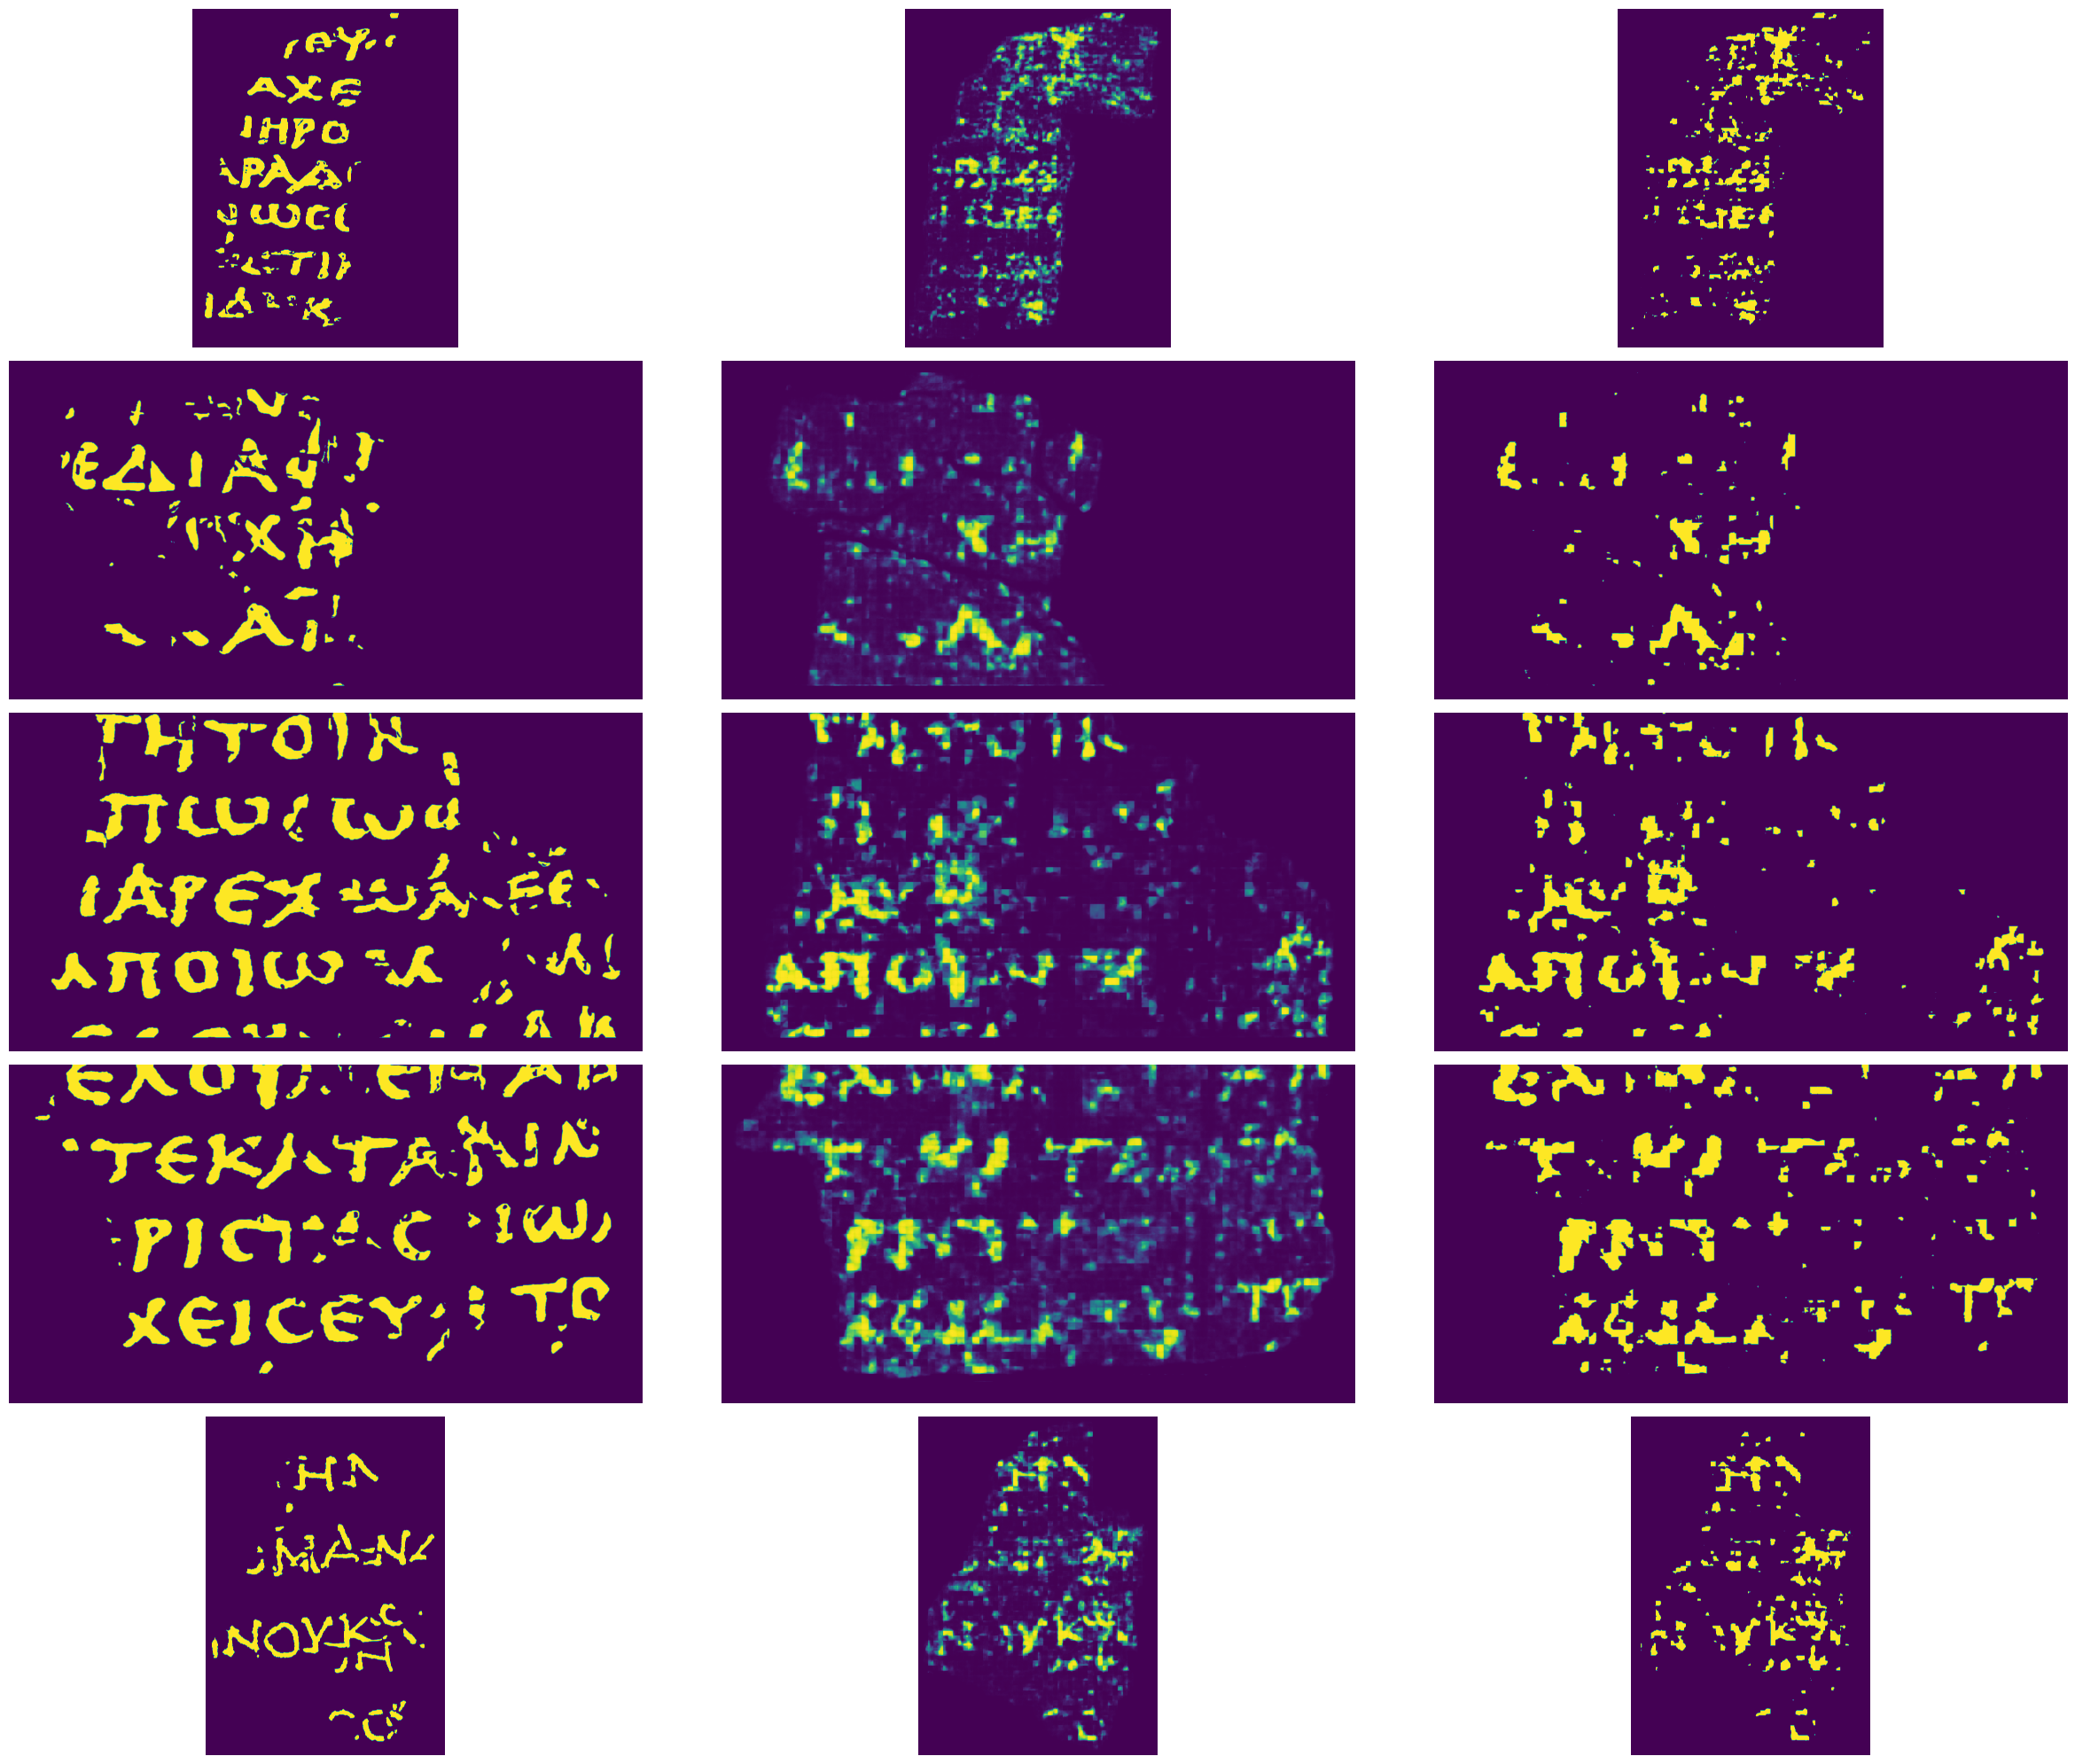

: 

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)